In [95]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

In [96]:
# read the words
words = open('names.txt', 'r').read().splitlines()
words[:8]  

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [97]:
# build the vocabulary and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [98]:
# build the dataset

def build_dataset(words, block_size=3):
    X, Y = [], []
    for word in words:
        # print(word)
        context = [0] * block_size # padded context of 0 tokens ('...' → e)
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '→', ch)
            context = context[1:] + [ix] # move context window by 1 – crop and append

    X = torch.tensor(X) # default for Tensor is float32 and for LongTensor is int64, tensor adjusts
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

In [99]:
# split the dataset 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
block_size = 3 # context length

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Build network

In [24]:
g = torch.Generator().manual_seed(2147483647)

hidden_layer_size = 200
embedding_dim = 10

# lookup table C
C = torch.randn([27, embedding_dim], generator=g)

# hidden layer
W1 = torch.randn((block_size * embedding_dim, hidden_layer_size), generator=g) * (5/3) / ((block_size * embedding_dim)**0.5)
# b1 = torch.randn(hidden_layer_size, generator=g) * 0.01

# output layer
W2 = torch.randn((hidden_layer_size, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

bngain = torch.ones((1, hidden_layer_size))
bnbias = torch.zeros((1, hidden_layer_size))
bnmean_running = torch.zeros((1, hidden_layer_size))
bnstd_running = torch.ones((1, hidden_layer_size))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [25]:
-torch.tensor(1/27.0).log() # we're expecting initial loss ~ 3.3

tensor(3.2958)

For random initialization on the 0th iteration we have very high loss (27.88), so the initialization is bad. We'd like to have an uniform distribution of logits (equal value).

To achieve this we can set b2 to 0 and scale down W2 to have less extreme values. Why not 0?

Also for h after this initialisation we have a lot of 1 and -1, because of the tanh. That's because hpreact is to far from 0. We can scale down W1 to have less extreme values.

tensor(0.0030) tensor(0.9979)
tensor(-0.0027) tensor(1.0039)


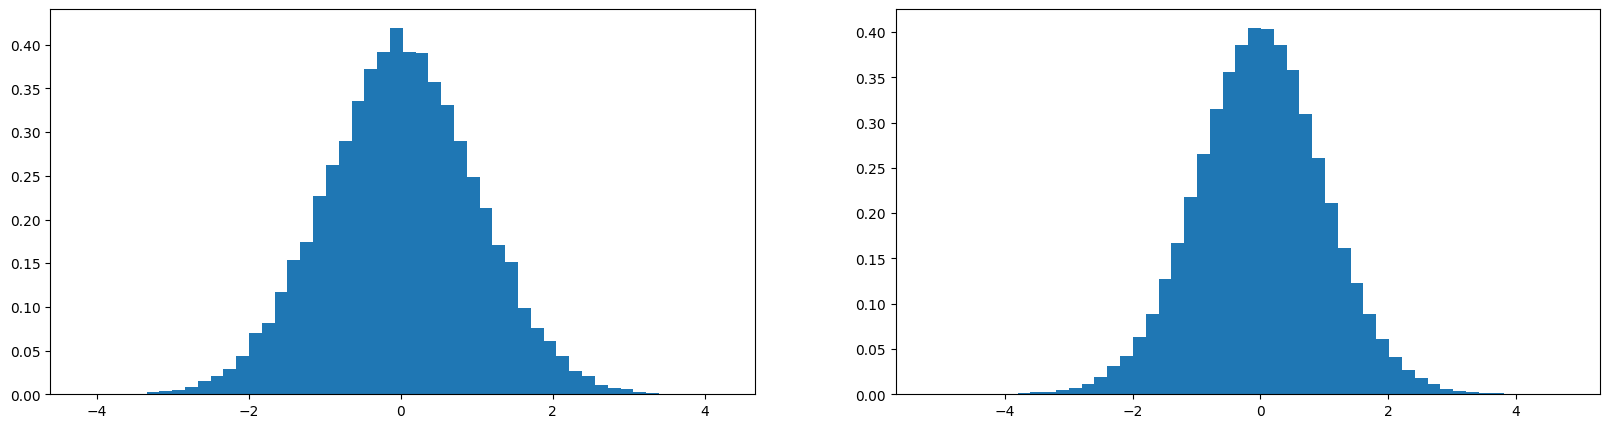

In [8]:
# How to find out how much should we scale the random weights?

x = torch.randn(1000, 30)
w = torch.randn(30, 200) / 30**0.5 # to keep output gaussian with std=1
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) #gaussian, but with more std – more extreme values
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), 50, density=True);

# it's called kaiming normal initialization

Now it's not so importnt to have a perfect initialisation beause of: residual connecion, normalization layers and more complex optimizer (eg. Adam).

In [26]:
sum(p.nelement() for p in parameters) # number of parameters in total

12097

In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construction
    ix = torch.randint(0 , Xtr.shape[0], (batch_size, ),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1# + b1 # hidden layer pre-activation
    # bias is useless with batchnorm, because it would be cancelled, so we just use batchnorm bias

    # batch normalization
    bnmeani =  hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi  + bnbias # not to divide by zero we add some very small epsilon to bnstd
    with torch.no_grad(): # slightly update mean and std for the whole dataset
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    h = torch.tanh(hpreact) # hidden layer
   
    # output layer
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707
2.013620376586914


BATCH NORMALIZATION

we want hidden state to be roughly gaussian, so we normalize them to be gausian. It's easily differentiable.

However we want the net to move around and not always be perfectly gaussian, so we add a learnable scale and shift. They start at 1 and 0 to be perfect gaussian, but they can change. 

Logits are now a function not only of an example, but also all other examples in batch. It turns out to be good, beacuse it works as a regularizer. It's like adding noise to the input. The network is less prone to overfitting.

However the grupping may cause unwanted effects, so there are more normalization layer which doesn't have this effect, e.g. group normalization.

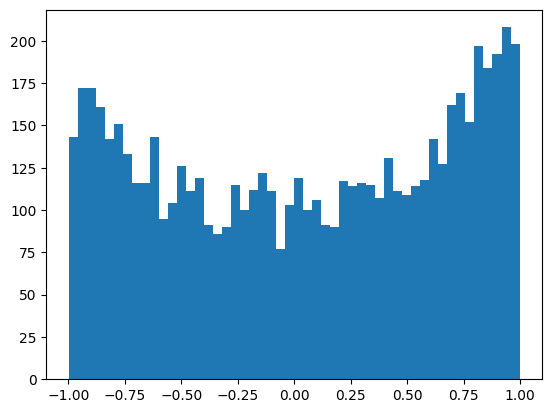

In [41]:
plt.hist(h.view(-1).tolist(), 50);

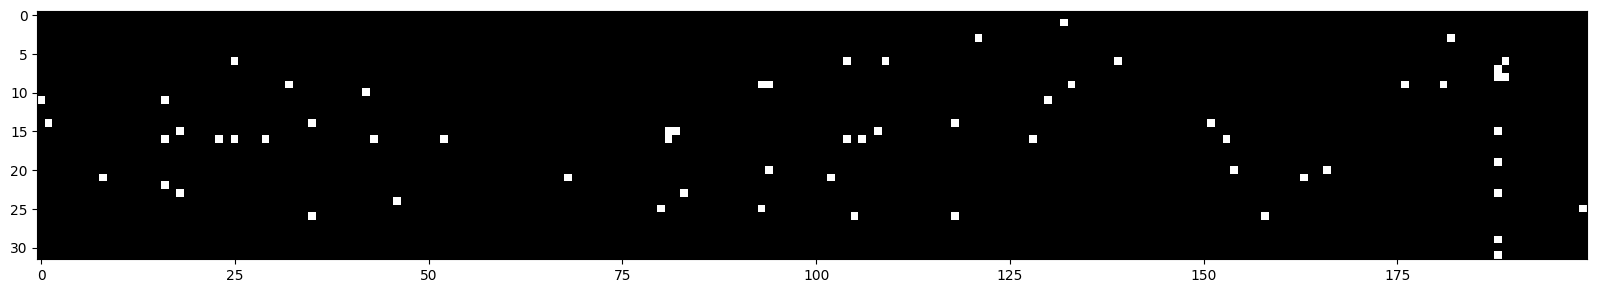

In [43]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation="nearest");

For randomly initialized first layer we have a lot of extreme values. When we backprop of tanh we take (1 - t**2) * out.grad, so we'll have 0, what is stopping the gradient flow – VANISHING GRADIENT.

The white dots are where backward gradient is destroyed. If any column were white, we'd have a dead neuron. However we have some of examples that activies each neuron, so we're learning something.

This is true for tanh, sigmoid (squishing functions), relu, elu (we have negative numbers coming in). Leaky reLU doesn't suffer so much.

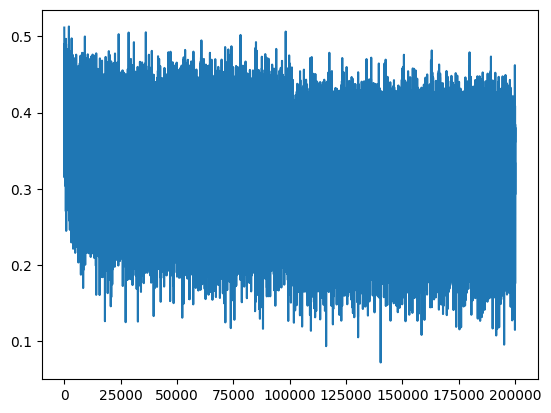

In [45]:
plt.plot(lossi)

After better initialization we don't have this hockey stick – easy part on the beginning. Thanks to this we can reach better score in the same number of iterations.

In [ ]:
# calibrate the batch norm at the end of training
# with torch.no_grad():
#     emb = C[Xtr] # on the whole training set
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     bnmean = hpreact.mean(0, keepdim=True) # fixed numbers
#     bnstd = hpreact.std(0, keepdim=True)

# we don't need it, because we can calculate it during training as running mean and running std
# bnmean, bnmean_running


In [18]:
# loss on the whole dataset
@torch.no_grad()
def split_loss(split):
    X,Y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    emb = C[X]
    hpreact = emb.view(-1, embedding_dim*block_size) @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running)/ bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss("train")
split_loss("dev")

train 2.0668835639953613
dev 2.1049437522888184


**original:**

train: 2.12</br>
dev: 2.17

**fix softmax confidently wrong (better init in second layer)**

train 2.0819787979125977</br>
dev 2.1412956714630127

**fix tanh too saturated (better init in first layer)**

train 2.0357086658477783</br>
dev 2.1029491424560547

The networ was shallowed so it learned even with many errors. It's not the case for deeper networks.

**add batchnorm**

train 2.0668835639953613</br>
dev 2.1049437522888184

In [18]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join([itos[i] for i in out]))

mora.
mayah.
seel.
nah.
yam.
rensleighdrae.
caileed.
elin.
shy.
jen.
eden.
estanaraelyn.
malke.
cayshuberlyni.
jest.
jair.
jenipanthono.
ubelleda.
kylynn.
els.


# Pytorchify

In [200]:
class Linear():
    def __init__(self, in_features, out_features, bias=True) -> None:
        self.W = torch.randn((in_features, out_features), generator=g) / (in_features**0.5)
        self.b = torch.zeros(out_features) if bias else None

    def __call__(self, input):
        self.out = input @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


class BatchNorm():
    def __init__(self, num_features: int, eps=1e-5, momentum=0.001):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backpropagation)
        self.gain = torch.ones(num_features) # gamma
        self.bias = torch.zeros(num_features) # beta
    
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(num_features)
        self.running_variance = torch.ones(num_features)

    def __call__(self, input):
        if self.training:
            # batch mean and std
            xmean =  input.mean(0, keepdim=True)
            xvar = input.var(0, keepdim=True)

            # update the buffers
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_variance = (1-self.momentum) * self.running_variance + self.momentum * xvar
        else:
            # mean and std estimation for all data
            xmean = self.running_mean
            xvar = self.running_variance
                    
        xhat = (input - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gain * xhat  + self.bias
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]
        

class Embedding():
    def __init__(self, num_embeddings: int, embedding_dim: int):
        self.C = torch.randn([num_embeddings, embedding_dim], generator=g)
    
    def __call__(self, input):
        self.out = self.C[input]
        return self.out  # embed the characters into vectors

    def parameters(self):
        return [self.C]

class Tanh():
    def __call__(self, input):
        self.out = torch.tanh(input)
        return self.out
    
    def parameters(self):
        return []


In [201]:
vocab_size = len(itos) # 27
n_hidden = 100 # number of neurons in the hidden layer
n_embd = 10 # embedding dimension
g = torch.Generator().manual_seed(2147483647)

emb_layer = Embedding(vocab_size, n_embd)

# layers =[
#     Linear(block_size * n_embd, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, vocab_size),
# ]

layers =[
    Linear(block_size * n_embd, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm(vocab_size)
]

# layers =[
#     Embedding(27, n_embd),
#     Linear(block_size * n_embd, n_hidden, bias=False),
#     Tanh(),
#     BatchNorm(n_hidden),
#     Linear(n_hidden, 27)
# ]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].W *= 0.1
    layers[-1].gain *= 0.1
    # all other layers: apply gain kaiming normal initialization
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3


parameters = emb_layer.parameters() + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47551


In [202]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):
    # minibatch construction
    ix = torch.randint(0 , Xtr.shape[0], (batch_size, ),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = emb_layer(Xb)
    output = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        output = layer(output)
    loss = F.cross_entropy(output, Yb)
    # print(loss.item())

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i == 1000:
        break

print(loss.item())

      0/ 200000: 3.2870
2.3104944229125977


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

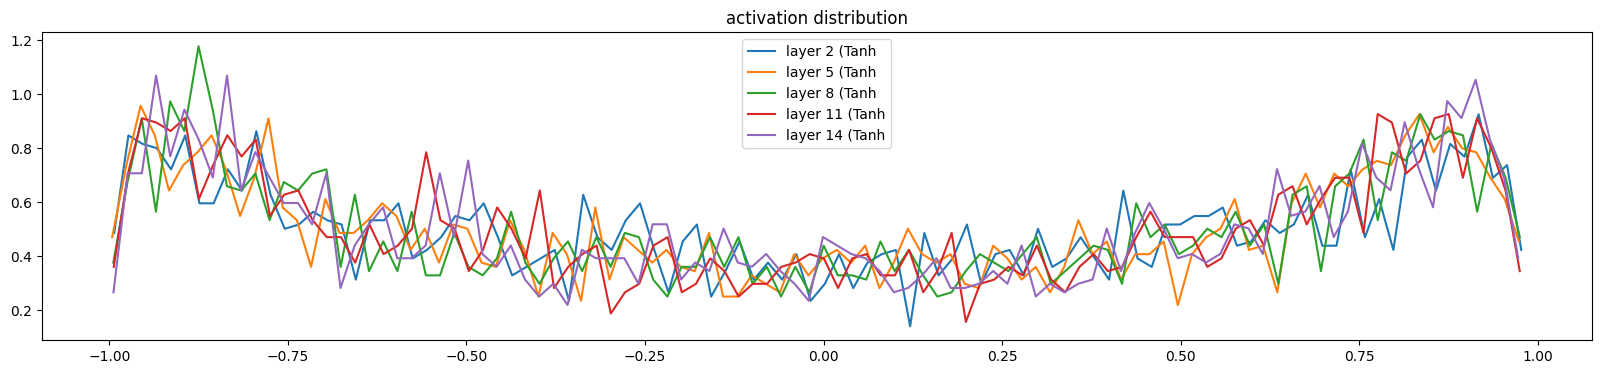

In [203]:
# visualize tanh outputs distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Saturation means how many outputs are near 1 or -1 – input is very high or very low value. It stops gradients. It depends on initialization. When we have low values (e.g. 1) we have very low saturation. It means tangent is too squashing. With very high values (e.g. 3) we have very high saturation, which will lead to vanishing gradient. With initialization with gain 5/3 we have high saturation on first layer, but low on the rest, which is good.

However, if we have batchnormalization, we don't have to pay so much attention to it.

layer 2 (      Tanh): mean -0.000000, std 3.682967e-03
layer 5 (      Tanh): mean +0.000000, std 3.262617e-03
layer 8 (      Tanh): mean +0.000000, std 2.973738e-03
layer 11 (      Tanh): mean +0.000000, std 2.741118e-03
layer 14 (      Tanh): mean -0.000000, std 2.584297e-03


Text(0.5, 1.0, 'gradient distribution')

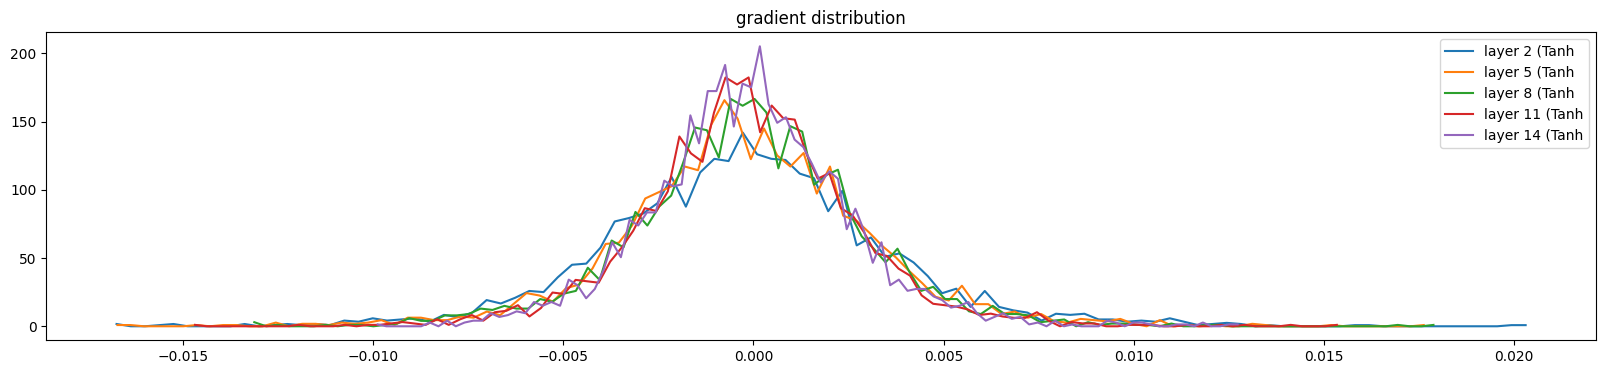

In [204]:
# visualize tanh gradients distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

They have roughly the same gradient. If we have too low gain, we have gradients really close to 0 and lowering from the last to the first layer.

If we don't have tanh, outputs of linear layers are not simillar. When we go deeper, the outputs begin to vary more and also the gradient diminishes when backpropagating. That's why initialization was very important. Without tanh we should set gain to 1.

weight   (27, 10) | mean -0.000000 | std 1.019893e-02 | grad:data ratio 1.018853e-02
weight  (30, 100) | mean +0.000092 | std 8.238461e-03 | grad:data ratio 2.635849e-02
weight (100, 100) | mean +0.000031 | std 7.318137e-03 | grad:data ratio 4.377159e-02
weight (100, 100) | mean -0.000019 | std 6.662035e-03 | grad:data ratio 3.949903e-02
weight (100, 100) | mean -0.000019 | std 5.821526e-03 | grad:data ratio 3.468167e-02
weight (100, 100) | mean +0.000053 | std 5.445308e-03 | grad:data ratio 3.243374e-02
weight  (100, 27) | mean -0.000165 | std 1.046847e-02 | grad:data ratio 6.281280e-02


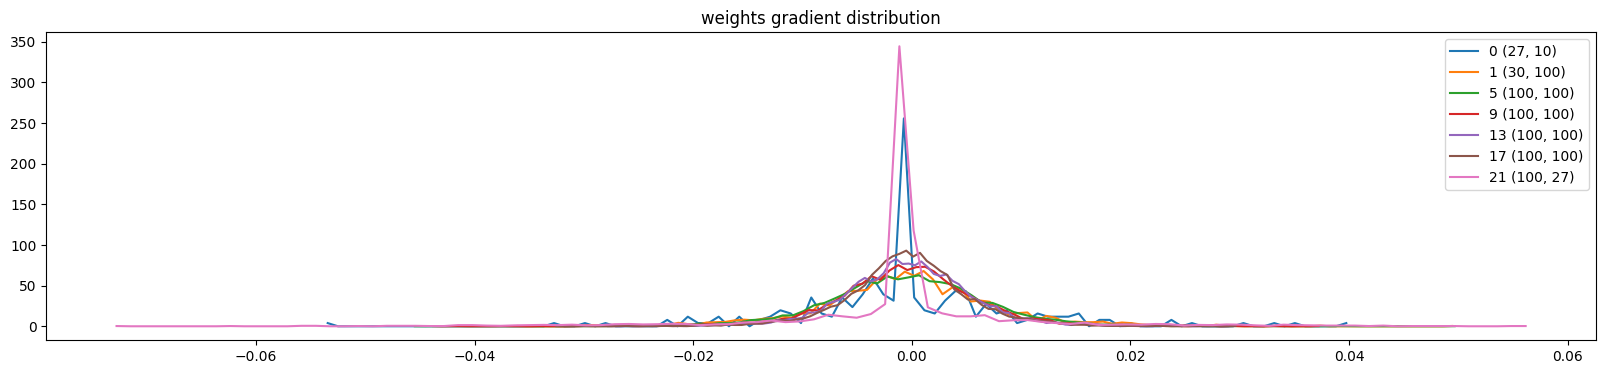

In [205]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # only for linear layers and look at weights
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Grad to data ratio is important, because we uptade parameters by it. Here theyre very low, with a difference in last layer. It has much bigger gradients, so it learns about 10 times faster than the others. It is getting better with more iterations.

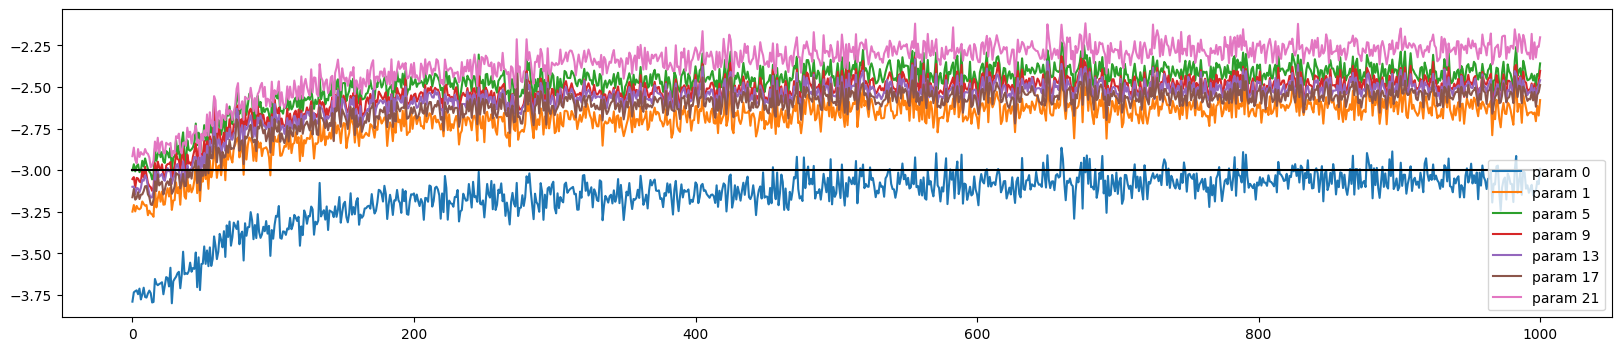

In [206]:
# update ratios over time
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # weights only
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

If the updates are a lot bigger than -1e-3, we are learning too fast. It's ok here, except of last layer. It's because we shrunk the values to very low values to have less confident values (*0.1). Normally they should learn at the same rate.

If they're below, we are learning too slow, e.g. we have too little learning rate.